# <center>Time Series Analysis on Europlt tower, interpolate from 10 minute data.</center>

## <center>(WORKING)Algorithm: Auto Regressive Integrated Moving Average model(ARIMA)</center>

### Import libraries

In [1]:
import numpy as np
import pandas as pd
import math

import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import itertools
import warnings
warnings.filterwarnings('ignore')

### Filename

In [4]:
filename ='europlt_processed.csv'

### Data

#### Cleaned tower data from KNMI, Dutch meteorological service, with 10 minutes intervals of wind speed
#### KNMI wind speed and direction observations
#### Europlatform station
#### Lat: 51.9978 Lon: 3.275 z: 29m above mean sea level
#### inititally collected from https://dataplatform.knmi.nl/dataset/windggevens-1-0
#### fields - wind speed FF_10m_10 (m/s)
#### gust speed FF_SENSOR_10 (m/s)
#### wind direction: DDN_10 (degrees)

In [5]:
europlt_wind = pd.read_csv(filename, delimiter=',', header=9)
europlt_wind.head()

,Datetime,LOCATION,NAME,LATITUDE,LONGITUDE,ALTITUDE,FF_10M_10,DD_10,DDN_10,DD_STD_10,DDX_10,FF_SENSOR_10,Flag
0,01/04/2003 00:10,321_W_0,Europlatform_locatie_0,51.997778,3.275,19,3.15,2.8079,150.5,3.1,3.3094,3.63,1
1,01/04/2003 00:20,321_W_0,Europlatform_locatie_0,51.997778,3.275,19,3.65,3.2536,153.6,1.9,3.7015,4.06,1
2,01/04/2003 00:30,321_W_0,Europlatform_locatie_0,51.997778,3.275,19,3.98,3.5478,156.8,1.9,3.9659,4.35,1
3,01/04/2003 00:40,321_W_0,Europlatform_locatie_0,51.997778,3.275,19,4.18,3.7261,159.9,2.5,4.3032,4.72,1
4,01/04/2003 00:50,321_W_0,Europlatform_locatie_0,51.997778,3.275,19,4.45,3.9668,164.0,2.8,4.5676,5.01,1


### Set time as the Index

In [6]:
europlt_wind.set_index('Datetime', inplace=True)
europlt_wind.head()

,LOCATION,NAME,LATITUDE,LONGITUDE,ALTITUDE,FF_10M_10,DD_10,DDN_10,DD_STD_10,DDX_10,FF_SENSOR_10,Flag
Datetime,,,,,,,,,,,,
01/04/2003 00:10,321_W_0,Europlatform_locatie_0,51.997778,3.275,19,3.15,2.8079,150.5,3.1,3.3094,3.63,1
01/04/2003 00:20,321_W_0,Europlatform_locatie_0,51.997778,3.275,19,3.65,3.2536,153.6,1.9,3.7015,4.06,1
01/04/2003 00:30,321_W_0,Europlatform_locatie_0,51.997778,3.275,19,3.98,3.5478,156.8,1.9,3.9659,4.35,1
01/04/2003 00:40,321_W_0,Europlatform_locatie_0,51.997778,3.275,19,4.18,3.7261,159.9,2.5,4.3032,4.72,1
01/04/2003 00:50,321_W_0,Europlatform_locatie_0,51.997778,3.275,19,4.45,3.9668,164.0,2.8,4.5676,5.01,1


### Find wind values and flags

In [7]:
wind_vals = europlt_wind[["FF_10M_10"]].to_numpy()
flags = europlt_wind[["Flag"]].to_numpy()
print(wind_vals[0:10])
print(len(wind_vals))
print(len(flags))

[[3.15]
 [3.65]
 [3.98]
 [4.18]
 [4.45]
 [4.14]
 [4.24]
 [4.47]
 [4.64]
 [5.25]]
989280
989280


### Replace wind values where flag is 0 with nan

In [12]:
loc_flags = np.where(flags < 1)
wind_vals[loc_flags[0]] = float('NaN')
# test around one point
print(wind_vals[loc_flags[0][450]-4:loc_flags[0][450]+5])


[[15.11]
 [16.33]
 [16.45]
 [16.97]
 [  nan]
 [  nan]
 [15.15]
 [15.59]
 [14.21]]


(array([   502,    762,   1770, ..., 977524, 979276, 984600]),
 array([0, 0, 0, ..., 0, 0, 0]))

### How much data must be removed due to flags?

In [9]:
pnan = len(loc_flags[0])/len(wind_vals)*100
print(f'percentage of points which are NaNs: {pnan:.2f}%')

percentage of points which are NaNs: 2.88%


### Split the whole data into train(April 2003 - End 2019) and test data (Jan 2020 - Feb 1st 2022)

In [10]:
split_point = europlt_wind.index[europlt_wind['Datetime'] == '31/12/2019 23:50']
wind_train = wind_vals[0:split_point[0]]
wind_test = wind_vals[split_point[0]: len(wind_vals)]

KeyError: 'Datetime'

### Next steps:
- ARIMA relies on timeseries repeating behaviour. 
- FInd if the timeseries is auto correlated or partially autocorrelated. 

### ACF and PACF plots

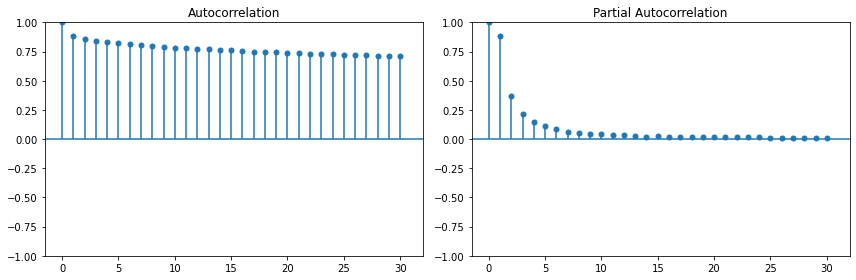

In [12]:
fig, axes = plt.subplots(1, 2, sharey=False, sharex=False)
fig.set_figwidth(12)
fig.set_figheight(4)
smt.graphics.plot_acf(~np.isnan(wind_train), lags=30, ax=axes[0], alpha=0.5)
smt.graphics.plot_pacf(~np.isnan(wind_train), lags=30, ax=axes[1], alpha=0.5)
plt.tight_layout()

-Highly autocorrelated, implies high wind follows high wind and low wind follows low wind - strong trends. 

- If there is seasonality, it will be better if we try all combinations of different parameters and choose the best set ofparameters that gives less AIC score.

### Parameters - p, d, q
- From above, d is known to be 1 (high autocorrelation). Also for 10 minute data, set seasonality = 0. 
- try all possible parameters and choose the best set of parameters that gives less AIC score for p and q.

In [10]:
# Define the p, d and q parameters to take any value between 0 and 5
d = 1

p = q = range(0, 3)

pq_vals = list(itertools.product(p, q))

# Generate all different combinations of seasonal p, q and q triplets
pdq = [(x[0], 1, x[1]) for x in list(itertools.product(p, q))]

In [11]:
pdq

[(0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2)]

In [12]:
AIC_scores_list = []

In [19]:
best_aic = np.inf
best_pdq = None
temp_model = None
for param in pdq:
        try:
            
            temp_model = sm.tsa.statespace.SARIMAX(~np.isnan(wind_train),
                                             order = param,
                                             enforce_stationarity=True,
                                             enforce_invertibility=True)
            results = temp_model.fit()
            l = []
            l.append(param[0])
            l.append(param[1])
            l.append(param[2])
            l.append(results.aic)
            AIC_scores_list.append(l)
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
        except:
            continue

print("Best SARIMAX{} model - AIC:{}".format(best_pdq, best_aic))

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.18784D+03    |proj g|=  5.90453D+06

At iterate    5    f= -1.04355D+00    |proj g|=  1.62501D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      6     36      1     0     0   1.623D-04  -1.044D+00
  F =  -1.0435543005249310     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.37897D-01    |proj g|=  1.26380D+01


 This problem is unconstrained.



At iterate    5    f= -8.34517D-01    |proj g|=  5.94290D-01

At iterate   10    f= -1.18692D+00    |proj g|=  8.92197D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     13     30      1     0     0   1.090D-03  -1.187D+00
  F =  -1.1869269574157946     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.79197D-01    |proj g|=  1.16691D+01


 This problem is unconstrained.



At iterate    5    f= -8.51463D-01    |proj g|=  5.74815D-01

At iterate   10    f= -1.19155D+00    |proj g|=  4.31422D-01

At iterate   15    f= -1.19206D+00    |proj g|=  5.34955D-02

At iterate   20    f= -1.19224D+00    |proj g|=  9.62029D-05



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     21     65      2     0     0   9.620D-05  -1.192D+00
  F =  -1.1922444995213350     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.42761D-01    |proj g|=  9.99722D+00


 This problem is unconstrained.



At iterate    5    f= -8.51944D-01    |proj g|=  4.38619D-01

At iterate   10    f= -1.12073D+00    |proj g|=  1.71101D+00

At iterate   15    f= -1.13259D+00    |proj g|=  1.85341D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     15     20      1     0     0   1.853D-04  -1.133D+00
  F =  -1.1325919264874273     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.81045D-01    |proj g|=  1.17233D+01


 This problem is unconstrained.



At iterate    5    f= -9.17885D-01    |proj g|=  3.96176D+00

At iterate   10    f= -1.17128D+00    |proj g|=  9.47581D-01

At iterate   15    f= -1.19342D+00    |proj g|=  3.65946D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     19     25      1     0     0   1.843D-05  -1.193D+00
  F =  -1.1934685952601638     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.66475D-01    |proj g|=  1.22039D+01

At iterate    5    f= -8.33427D-01    |proj g|=  4.57669D-01

At iterate   10    f= -1.07158D+00    |proj g|=  1.83037D-01

At iterate   15    f= -1.19479D+00    |proj g|=  4.63505D-01

At iterate   20    f= -1.19610D+00    |proj g|=  1.96207D-03

At iterate   25    f= -1.19624D+00    |proj g|=  1.54018D-01

At iterate   30    f= -1.19747D+00    |proj g|=  6.82354D-02

At iterate   35    f= -1.19772D+00    |proj g|=  5.34338D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.95217D-01    |proj g|=  1.13175D+01

At iterate    5    f= -8.54616D-01    |proj g|=  4.49905D-01

At iterate   10    f= -1.03196D+00    |proj g|=  6.54441D-01

At iterate   15    f= -1.16074D+00    |proj g|=  5.98507D-02

At iterate   20    f= -1.16084D+00    |proj g|=  5.06892D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     31      1     0     0   5.069D-05  -1.161D+00
  F =  -1.1608432192901574     

CONVERG

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.03389D+00    |proj g|=  2.70355D+00

At iterate    5    f= -1.16233D+00    |proj g|=  1.25189D-01

At iterate   10    f= -1.17303D+00    |proj g|=  3.38527D-01

At iterate   15    f= -1.17383D+00    |proj g|=  2.78898D-01

At iterate   20    f= -1.18797D+00    |proj g|=  1.20785D+00

At iterate   25    f= -1.19547D+00    |proj g|=  1.34033D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     37      1     0     0   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.65819D-01    |proj g|=  1.22212D+01

At iterate    5    f= -8.91975D-01    |proj g|=  2.89789D+00

At iterate   10    f= -1.02372D+00    |proj g|=  1.82259D-01

At iterate   15    f= -1.13931D+00    |proj g|=  4.21717D-01

At iterate   20    f= -1.18652D+00    |proj g|=  3.34238D-01

At iterate   25    f= -1.19590D+00    |proj g|=  1.22383D-03

At iterate   30    f= -1.19680D+00    |proj g|=  1.73449D-02

At iterate   35    f= -1.19822D+00    |proj g|=  4.74467D-02

At iterate   40    f= -1.19863D+00    |proj g|=  5.54615D-02

At iterate   45    f= -1.19881D+00    |proj g|=  3.87150D-03

At iterate   50    f= -1.19883D+00    |proj g|=  3.01561D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

In [20]:
print(AIC_scores_list)
print(best_pdq)
print(best_aic)

#AIC_scores = pd.DataFrame.from_records(AIC_scores_list)
#AIC_scores.columns=['p', 'd', 'q', 'AIC']
#AIC_scores.iloc[AIC_scores['AIC'].argmin()]

[[0, 1, 0, -1835714.3700534063], [0, 1, 1, -2087919.2107901243], [0, 1, 2, -2097271.2991079804], [1, 1, 0, -1992338.4578840334], [1, 1, 1, -2099424.605922154], [1, 1, 2, -2106908.6927828607], [2, 1, 0, -2042033.307053316], [2, 1, 1, -2102944.8520229016], [2, 1, 2, -2108848.2332024775]]
(2, 1, 2)
-2108848.2332024775


### Analysis:
- After fitting the data with different combination of models, we got the best parameters as following:
    - p = 2, d = 1, q = 2
    

In [21]:
best_pdq = (2, 1, 2)

### Use the best parameters and build a model

In [22]:
best_model = sm.tsa.statespace.SARIMAX(~np.isnan(wind_train),
                                      order=best_pdq,
                                      enforce_stationarity=True,
                                      enforce_invertibility=True)
best_results = best_model.fit()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.65819D-01    |proj g|=  1.22212D+01

At iterate    5    f= -8.91975D-01    |proj g|=  2.89789D+00

At iterate   10    f= -1.02372D+00    |proj g|=  1.82259D-01

At iterate   15    f= -1.13931D+00    |proj g|=  4.21717D-01

At iterate   20    f= -1.18652D+00    |proj g|=  3.34238D-01

At iterate   25    f= -1.19590D+00    |proj g|=  1.22383D-03

At iterate   30    f= -1.19680D+00    |proj g|=  1.73449D-02

At iterate   35    f= -1.19822D+00    |proj g|=  4.74467D-02

At iterate   40    f= -1.19863D+00    |proj g|=  5.54615D-02

At iterate   45    f= -1.19881D+00    |proj g|=  3.87150D-03

At iterate   50    f= -1.19883D+00    |proj g|=  3.01561D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

In [24]:
print(best_results.summary().tables[0])

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:               879550
Model:               SARIMAX(2, 1, 2)   Log Likelihood             1054429.117
Date:                Wed, 30 Mar 2022   AIC                       -2108848.233
Time:                        20:24:23   BIC                       -2108789.797
Sample:                             0   HQIC                      -2108832.069
                             - 879550                                         
Covariance Type:                  opg                                         


### Get predictions 

In [26]:
pd.to_datetime('2020-01-01 00:10')

Timestamp('2020-01-01 00:10:00')

In [41]:
pred_dynamic = best_results.get_prediction(start=0, dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

### Extract the predicted and true values of our time series

In [46]:
wind_predicted = pred_dynamic.predicted_mean
wind_truth = ~np.isnan(wind_test)
np.min(wind_predicted)

0.0

### Compute the mean square error

In [36]:
mse = math.sqrt(((wind_predicted - wind_truth) ** 2).mean())
print('The Mean Squared Error of our predictions is {}'.format(round(mse, 4)))

The Mean Squared Error of our predictions is 0.0949


In [43]:
rainfall_data.index[-1]

Timestamp('1994-12-01 00:00:00', freq='MS')

### Visuaization of true and predicted values

In [44]:
rainfall_dummy_data = rainfall_data
rainfall_dummy_data.columns = ['Train data']

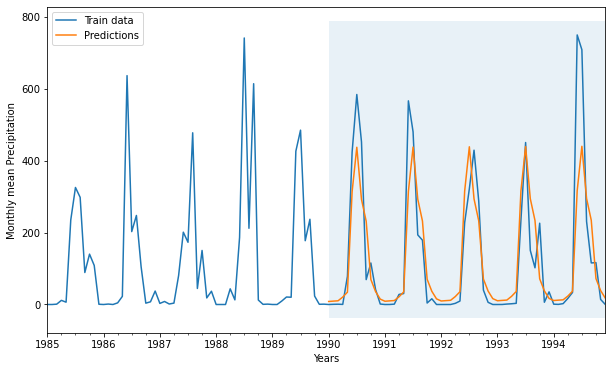

In [45]:
# Plot the actual values.
axis_plt = rainfall_dummy_data['1985':].plot(label='Train data', figsize=(10, 6))

# Plot the predicted values.
pred_dynamic.predicted_mean.plot(ax=axis_plt, label='Predictions')

# Plot confidence values and fill it with some colour.
# axis_plt.fill_between(pred_dynamic_ci.index, pred_dynamic_ci.iloc[:, 0], pred_dynamic_ci.iloc[:, 1], color='k', alpha=0.1)
axis_plt.fill_betweenx(axis_plt.get_ylim(), pd.to_datetime('1990'), rainfall_data.index[-1], alpha=0.1, zorder=-1)

# Set labels.
axis_plt.set_xlabel('Years')
axis_plt.set_ylabel('Monthly mean Precipitation')

# Put legend on the plot at the best place it fits.
plt.legend(loc='best')

### Forecast
- Predict Precipitation for next 7 years.

In [46]:
# Get forecast 96 steps (8 years) ahead in future
n_steps = 96
pred_uc_95 = best_results.get_forecast(steps=n_steps, alpha=0.05) # alpha=0.05 95% CI

# Get confidence intervals 95% of the forecasts
pred_ci_95 = pred_uc_95.conf_int()

In [47]:
# index = pd.date_range(rainfall_data.index[-1] + 1, periods=n_steps, freq='MS')
index = pd.date_range(rainfall_data.index[-1] + 1*rainfall_data.index[-1].freq, periods=n_steps, freq='MS')
forecast_data = pd.DataFrame(np.column_stack([pred_uc_95.predicted_mean, pred_ci_95]), 
                     index=index, columns=['forecast', 'lower_ci_95', 'upper_ci_95'])

forecast_data.head()

,forecast,lower_ci_95,upper_ci_95
1995-01-01,11.753433,-173.841143,197.348008
1995-02-01,12.528777,-173.065841,198.123395
1995-03-01,13.425796,-172.168843,199.020434
1995-04-01,23.487771,-162.106888,209.082430
1995-05-01,38.512415,-147.082264,224.107094


### Plot the forecast along with confidence band

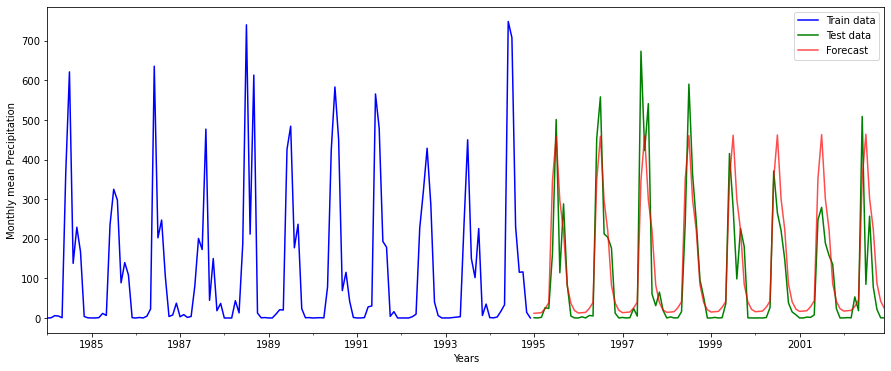

In [48]:
axis_plt = rainfall_dummy_data['1984':].plot(label='Observed', color='blue', figsize=(15, 6))

test_rainfall_data.Precipitation.plot(ax=axis_plt, color='green', label='Test data')
forecast_data['forecast'].plot(ax=axis_plt, label='Forecast', alpha=0.7, color='r')

# axis_plt.fill_between(forecast_data.index, forecast_data['lower_ci_95'], forecast_data['upper_ci_95'], color='k', alpha=.25)

axis_plt.set_xlabel('Years')
axis_plt.set_ylabel('Monthly mean Precipitation')
plt.legend(loc='best')

In [49]:
dummy_test_data = test_rainfall_data
dummy_test_data.columns = ['Test data']

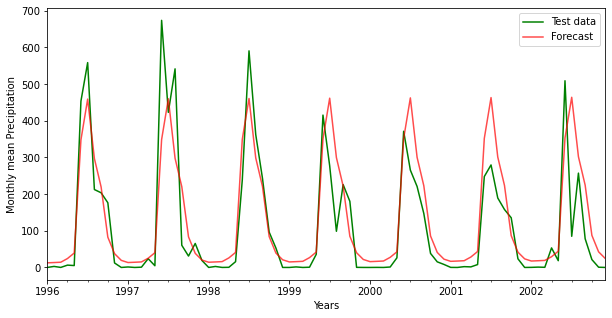

In [50]:
axis_plt = dummy_test_data['1996':].plot(label='Actual values', figsize=(10, 5), color='green')
forecast_data['forecast']['1996':].plot(ax=axis_plt, label='Forecast', alpha=0.7, color='r')

axis_plt.set_xlabel('Years')
axis_plt.set_ylabel('Monthly mean Precipitation')
plt.legend(loc='best')

### Mean square error of the forecasts

In [51]:
y_true = test_rainfall_data['1995-01-01':]['Test data']
y_forecast = forecast_data['forecast']

In [52]:
mse = math.sqrt(((y_true - y_forecast) ** 2).mean())
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 4)))

The Mean Squared Error of our forecasts is 89.2525


### MAPE

In [53]:
mape = np.mean(np.abs((y_true - y_forecast) / (y_true))) * 100
print('The MAPE of our forecasts is {}'.format(round(mape, 4)))

The MAPE of our forecasts is inf


In [54]:
def mape_vectorized_v2(a, b): 
    mask = a != 0
    return (np.fabs(a - b)/a)[mask].mean()

In [55]:
mape_vectorized_v2(y_true, y_forecast)

158.000619460752

In [56]:
RMSE_data = [['Train RMSE', 97.66, 74.58],
            ['Test RMSE', 89.25, 91.69]]

In [57]:
RMSE_data_df = pd.DataFrame.from_records(RMSE_data)
RMSE_data_df.columns = ['Type of Data', 'RMSE of ARIMA', 'RMSE of LSTM']
RMSE_data_df

,Type of Data,RMSE of ARIMA,RMSE of LSTM
0,Train RMSE,97.66,74.58
1,Test RMSE,89.25,91.69


Text(0.5, 1.0, 'ARIMA - Train and Test RMSE')

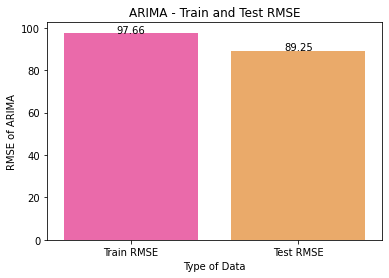

In [58]:
g = sns.barplot(x='Type of Data', y='RMSE of ARIMA', data=RMSE_data_df, palette='spring')
for index, row in RMSE_data_df.iterrows():
    g.text(row.name, row['RMSE of ARIMA'], round(row['RMSE of ARIMA'],2), color='black', ha="center")
plt.title('ARIMA - Train and Test RMSE')

Text(0.5, 1.0, 'LSTM - Train and Test RMSE')

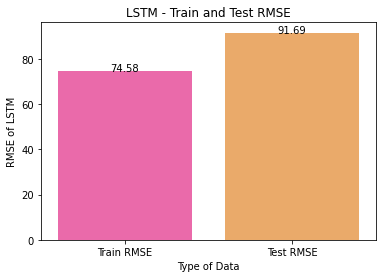

In [59]:
g = sns.barplot(x='Type of Data', y='RMSE of LSTM', data=RMSE_data_df, palette='spring')
for index, row in RMSE_data_df.iterrows():
    g.text(row.name, row['RMSE of LSTM'], round(row['RMSE of LSTM'],2), color='black', ha="center")
plt.title('LSTM - Train and Test RMSE')

Text(0.5, 1.0, 'Comparison of train and test RMSE of two algorithms')

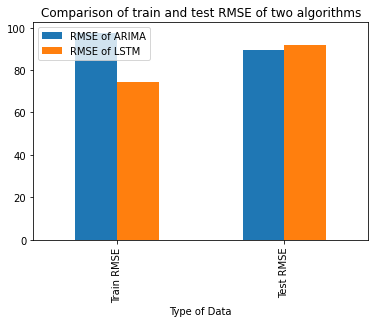

In [60]:
RMSE_data_df.plot(x="Type of Data", y=["RMSE of ARIMA", "RMSE of LSTM"], kind="bar")
plt.title('Comparison of train and test RMSE of two algorithms')

In [ ]:
# Throws an error, unsure why
sns.barplot(x='Type of Data', y=['RMSE of ARIMA', 'RMSE of LSTM'], hue='Type of Data', data=RMSE_data_df, palette='spring')